# Netflix ratings analysis

## Introduction
This project aims to analyse the ratings of Netflix movies and TV shows.
### Dataset 
The dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc. as of mid 2021.
https://www.kaggle.com/datasets/shivamb/netflix-shows

### Importing required libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

### Loading data

In [ ]:
try:
    df = pd.read_csv("../data/netflix_titles.csv")
    if df.empty:
        raise ValueError("Loaded empty DataFrame")
    else:
        print("Data Loaded successfully")
except FileNotFoundError:
    print("File 'netflix_titles.csv' not found")
except Exception as e:
    print(f"[ERROR] An unexpected error occurred: {type(e).__name__}: {e}")

### Data Overview

In [ ]:
print(f"Total columns:\t{df.shape[1]}")
print(f"Total rows:\t{df.shape[0]}")
print(f"Column names:\n{list(df.columns)}")


df.info()
display(df.head(2))
display(df.tail(2))

### Data information:
There are total 12 columns.  
Issues found  
missing values in mulitple columns.  
3 in duration  
4 in ratings  
10 in date_added  
over 800 in cast  
over 800 in country  
over 2500 in director  
date_added is object type.


In [ ]:
# Missing Data Heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(),
            cbar=False,
            cmap='viridis')
plt.title("Missing Data Heatmap")
plt.xticks(rotation=45)
plt.show()

### Data Cleaning
First convert wrong data types into correct usable ones (e.g. 'duration' from string to time, 'rating' from string to float)

Backup the original dataset before transformations

In [ ]:
# Duplicate dataframe for recovery
dff = df.copy() 

In [ ]:
# column wise cleaning

# standardize capitalization
df['type'] = df['type'].str.strip().str.title()

# removing extra whitespace
df['title'] = df['title'].str.strip() 

# Fill empty cells with Unknown
df['director'] = df['director'].fillna("Unknown")
df['cast'] = df['cast'].fillna("Unknown")
df['country'] = df['country'].fillna("Unknown")

# convert from string to datetime
# leave inavlid/empty dates as NaT
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')



# fill 'Unknown' to empty cells, remove blank space, and convert to upper case
df['rating'] = df['rating'].fillna('Unknown').str.strip().str.upper()

# Replace rare rating categories (frequency < 10) with 'Other'

rating_count = df['rating'].value_counts()
rare_rating_count = rating_count[rating_count < 10]
rare_rating_categories = rare_rating_count.index
df['rating'] = df['rating'].replace(rare_rating_categories, 'Other')
df['rating'].value_counts()
# since there were only 4 'UNKNOWN' values they were replaced with Other



In [ ]:
# clean remaining columns - duration, listed_in, description
# duration column has 'x min' for movies and 'x seasons' for TV shows
# create two new columns seaparating them 'duration_time' and 'duration_type' 

# using column wise sending

def extract_time(x):
    try:
        if pd.isna(x):
            return np.nan
        return int(x.strip().split()[0])
    except Exception:
        return np.nan
    
def extract_type(x):
    try:
        if pd.isna(x):
            return np.nan
        else:
            return x.strip().split()[1]
    except Exception:
        return np.nan
    
df['duration_time'] = df['duration'].apply(extract_time)
df['duration_type'] = df['duration'].apply(extract_type)


In [ ]:
# row-wise sending row
# creating colums 'duration_time' and 'duration_type' 
"""def extract_time(row):
    try:
        if pd.isna(row['duration']):
            return np.nan
        else:
            return int(row['duration'].strip().split()[0])
    except Exception:
        return np.nan
    
def extract_duration(row):
    try:
        if pd.isna(row['duration']):
            return np.nan
        else:
            return row['duration'].strip().split()[1]
    except Exception:
        return np.nan

df['duration_time'] = df.apply(extract_time, axis=1)
df['duration_type'] = df.apply(extract_duration, axis=1)"""
# for demonstration purpose only

In [ ]:
# Standardize duration units 
# convert mins to min and seasons to season
df['duration_type'] = df['duration_type'].replace({
    'mins': 'min',
    'Seasons': 'Season',
    'seasons': 'Season'
})


df['listed_in'] = df['listed_in'].str.strip()
# df['listed_in'] = df['listed_in'].apply(lambda x: ', '.join(i.strip() for i in x.split(',')) if pd.notna(x) else x)

df['description'] = df['description'].str.strip()


In [ ]:
# remove duplicates
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['title'], inplace=True)
df.drop_duplicates(subset='show_id', inplace=True)
df.reset_index(drop=True, inplace=True) #drop used to drop old index


In [ ]:
# numeric columns list
df.info()
numeric_cols = ['release_year']

### Save cleaned data into new csv file 'netflix_cleaned.csv'

In [ ]:
df.to_csv("../data/netflix_cleaned.csv")

## Analysis

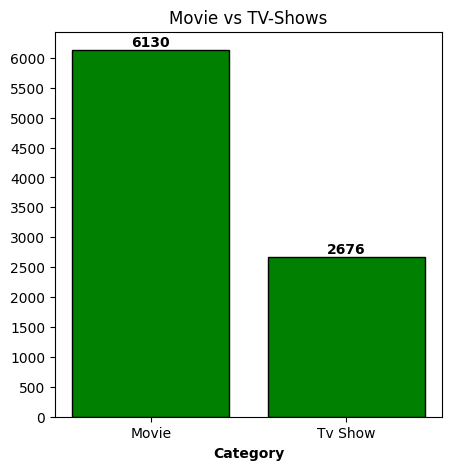

In [18]:
# Movie vs Tv-shows count
def count_using_seaborn():

    plt.figure(figsize=(5,5))
    ax = sns.countplot(data=df, x='type', color='yellow', edgecolor='black')
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height+0.10, 
                str(height),
                ha='center',
                va='bottom',
                fontweight='bold')
    plt.title("Movie vs TV-Shows")
    plt.xlabel("Category")
    plt.show()
    plt.savefig("../plots/movie_tv_shows_count")


def count_using_matplotlib():
    type_count = df['type'].value_counts()
    ls = np.arange(0, type_count.values.max(), 500)
    plt.figure(figsize=(5,5))
    bars = plt.bar(type_count.index, type_count.values, color='green', edgecolor='black')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, height+10, 
                str(height), 
                ha='center',
                va='bottom', 
                fontweight='bold'
                )
    
    plt.yticks(ls)
    plt.title("Movie vs TV-Shows")
    plt.xlabel("Category", fontdict={'fontweight':'bold'})
    plt.savefig("../plots/movie_tv_shows_count")
    plt.show()

count_using_matplotlib()
# count_using_seaborn()

**Insights**  
Movies are almost 2 times than Tv shows

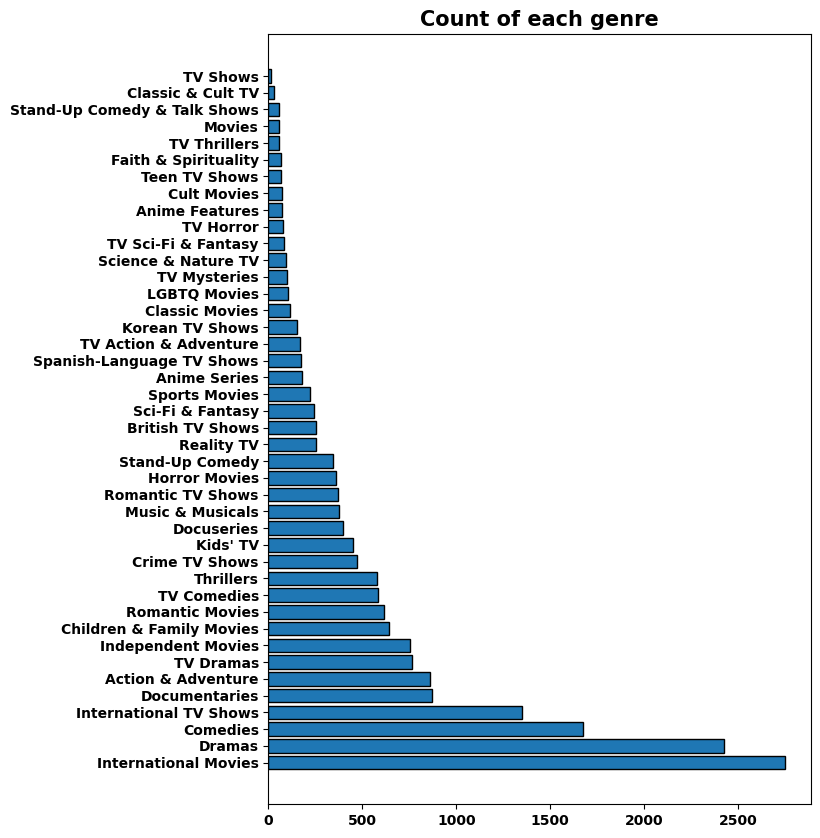

In [19]:
# genre distribution
# cells in df['listed_in'] can have more than 1 genre seaprated by ','
# split each cell's item by ',' 
# and remove extra blsnkspace


# or in simplere way

# all_genre = []
# for item in df['listed_in']:
#     genres = item.split(',')          # Split the string into a list of genres
#     for g in genres:
#         all_genre.append(g.strip())   # Strip spaces and append to final list

def plot_genre_distribution():
    all_genre = []
    all_genre = [g.strip() for item in df['listed_in'] for g in item.split(',') ]
    all_genre_count = pd.Series(all_genre).value_counts()
    all_genre_count


    plt.figure(figsize=(7,10))
    plt.xticks(rotation=90)
    plt.title("Count of each genre", fontsize=15, fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xticks(rotation=360, fontweight='bold')

    plt.barh(all_genre_count.index, all_genre_count.values, edgecolor='black')
    # plt.barh( all_genre_count.index, all_genre_count.values)
    # sns.countplot(data=flat_genres, order=order)
    plt.savefig("../plots/genre_distribution.png")
    plt.show()
plot_genre_distribution()

**Insights**  
International Movies is the most common content type, followed by Dramas and Comedies

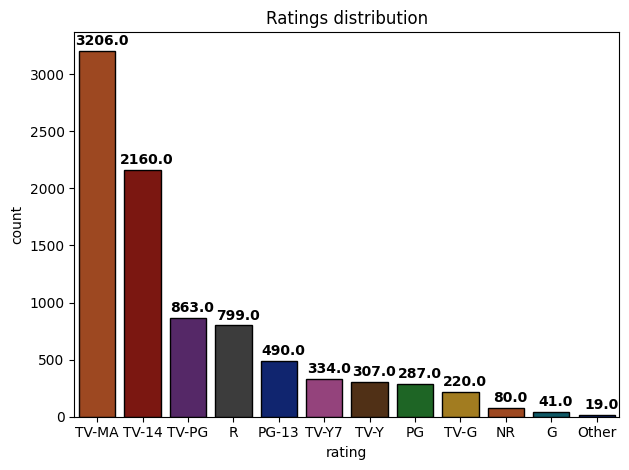

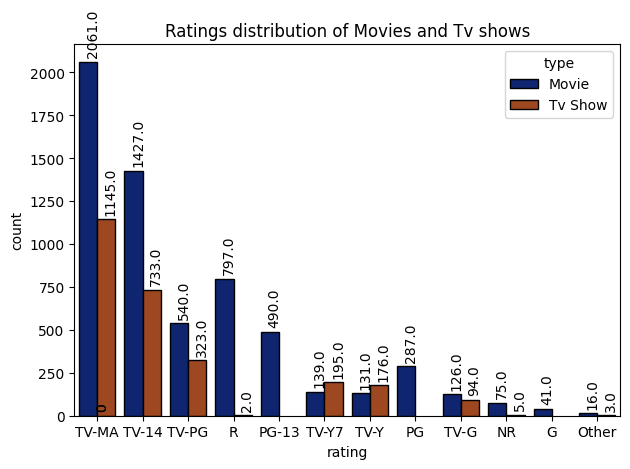

In [24]:
# Ratings Distribution

def plot_ratings_distribution(category):
    if category=='separate':
        ax = sns.countplot(data=df, x='rating'
              ,order=df['rating'].value_counts().index,
              edgecolor='black',
              hue='type',
              palette='dark')
    else :
        ax = sns.countplot(data=df,
              x='rating',
              order=df['rating'].value_counts().index,
              color='green',
              edgecolor='black',
              hue='rating', # added hue for using palette
              palette='dark')
    for bar in ax.patches:
        height = bar.get_height()
        x = bar.get_x() + bar.get_width()/2 + 0.1 # extra 0.1 for better eadability
        y = height + 25
        if category=='separate': # rotate annotaion by 90
            ax.text(x,y, str(height), ha='center', va='bottom', rotation = 90)
        else: # do not rotate annotation
            ax.text(x,y, str(height), ha='center', va='bottom', fontweight='bold')
    

    if category=='separate': # rotate annotaion by 90
        plt.title("Ratings distribution of Movies and Tv shows")
        plt.savefig("../plots/ratings_distribution_separate.png")
    else:
        plt.savefig("../plots/ratings_distribution_merged.png")
        plt.title("Ratings distribution")
    plt.tight_layout()
    plt.show()

plot_ratings_distribution(None) # Combined ratings in green
plot_ratings_distribution('separate') # Separate bars by 'type'


**Insights**  
TV-MA is the most common rating.
TV-14 is second most common rating.
Most of content in Netflix is not for children or need adult supervision.

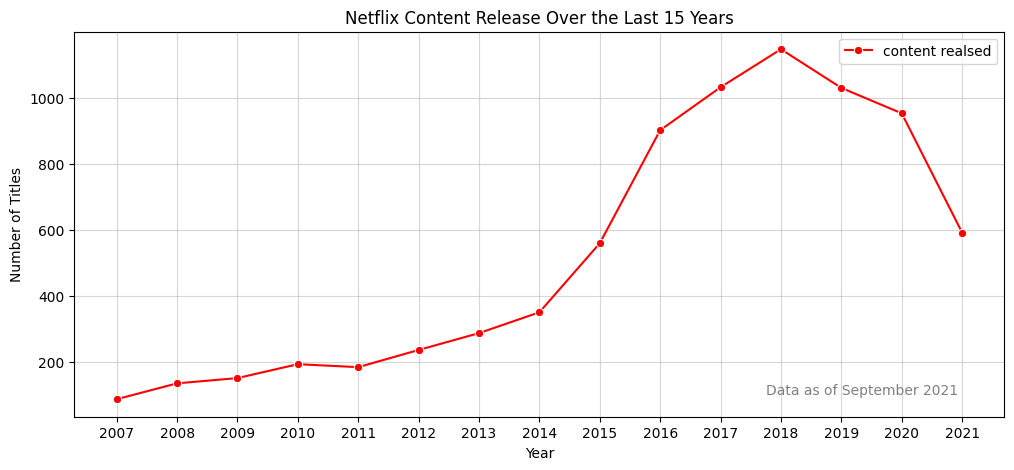

In [26]:
# content realsed by Netflix in last n years
def plot_content_releases(last_n_years=10):
    total_content_per_year = df['release_year'].value_counts()
    data = total_content_per_year.sort_index(ascending=False).head(last_n_years)
    # display(data)
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=data.index, y=data.values, marker='o', color='red', label="content realsed")
    plt.title(f"Netflix Content Release Over the Last {last_n_years} Years")
    plt.xlabel("Year")
    plt.ylabel("Number of Titles")
    plt.grid(True, alpha=0.5)
    
    max_year = data.index.max()
    min_year = data.index.min()
    plt.xticks(np.arange(min_year, max_year+1, 1))

    
    
    plt.annotate(
        f"Data as of September 2021",
        xy=(0.95, 0.05),
        xycoords='axes fraction',
        # xycoords='figure fraction',

        ha='right',
        va='bottom',
        fontsize=10,
        color='gray'
    )
    plt.savefig(f"../plots/content_released_over_{last_n_years}.png")

    plt.show()

n_years = 15 # last n years of data
plot_content_releases(n_years)

**Insights**  
*Data From 2007 to mid 2021:*  
Netflix releases kept rising since 2007 and saw first minor drop in 2011.  
Netflix content released doubled almost every 2 years from 2011 to 2016.  
In 2018 netflix released highest number of content in its history with over 1100 production.  
The second drop was in 2019 and kept decreasing.  


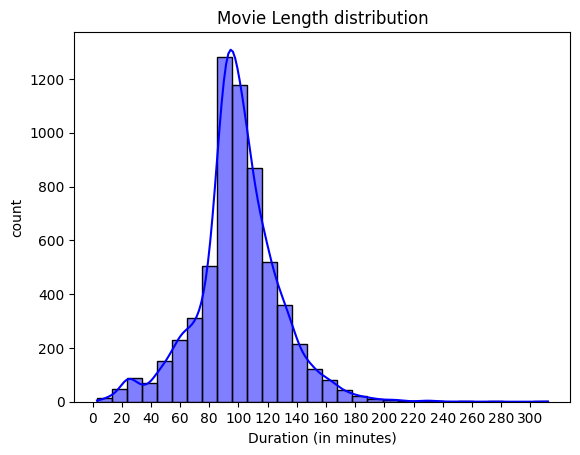

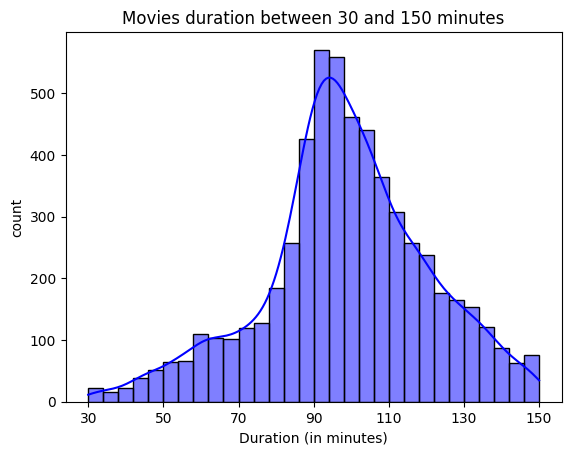

In [29]:
# Movie length distribution
def distribute():
    df_movies = df[df["type"] == 'Movie'].copy()
    df_movies = df_movies[df_movies['duration_time'].notna()]

    df_movies['duration_time'] = df_movies['duration_time'].astype(float)
    return df_movies


# confirm duration to be float
# df_movies.info()
def all_movies():
    df_movies = distribute()
    sns.histplot(df_movies['duration_time'], bins=30, kde=True, color='blue', edgecolor='black')
    plt.xlabel("Duration (in minutes)")
    plt.ylabel('count')
    plt.title("Movie Length distribution")
    plt.xticks(np.arange(0, df_movies['duration_time'].max(), 20))
    plt.savefig("../plots/moview_length_distribution.png")
    plt.show()

def movie_length_x_y(min_time=30, max_time=200):
    df_movies = distribute()
    filtered = df_movies[(df_movies['duration_time']>=min_time) & (df_movies['duration_time']<=max_time)]
    
    sns.histplot(filtered['duration_time'], bins=30, kde=True, color='blue', edgecolor='black')
    
    plt.title(f"Movies duration between {min_time} and {max_time} minutes")
    plt.xlabel("Duration (in minutes)")
    plt.ylabel('count')
    plt.xticks(np.arange(30, filtered['duration_time'].max()+20, 20))
    plt.savefig(f"../plots/moview_length_distribution{min_time}_to_{max_time}_mins.png")

    plt.show()
all_movies()
movie_length_x_y(min_time=30,max_time=150)

**Insights**  
Most movies are 80 to 130 minutes long.  
Few movies of length smaller than 50 minutes, some were even less than of 10 or 5 minutes.  
Few movies over 160 minutes, and some surpassed 300 minutes.

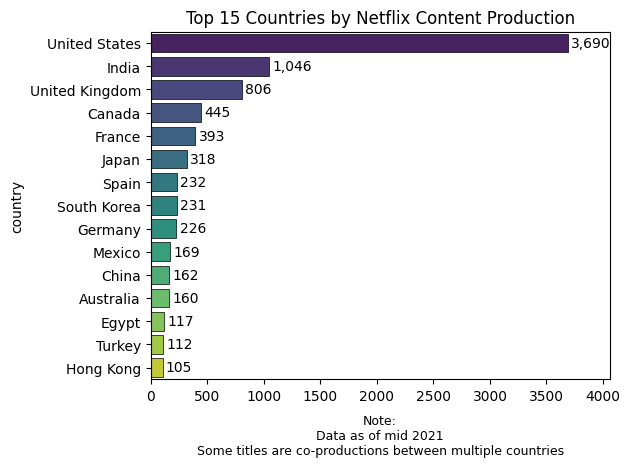

In [33]:
# Top content producing countires

def content_producing_countries():
    df_country = df['country'].dropna() # drop rows wiht no country
    df_country = df_country[df_country != 'Unknown'] # remove Unknown countires

    # since a cell can contain multiple countres separated by ','
    # split each string into a list of countries
    df_country = df_country.apply(lambda x: x.split(','))

    # remove blank spaces from each country name in list
    df_country = df_country.apply(lambda x: [item.strip() for item in x])
    # Flatten the list
    df_country = df_country.explode()

    df_country = df_country.value_counts().head(15) # select only top 15


    ax = sns.barplot(
            x=df_country.values,
            y=df_country.index,
            hue=df_country.index,  # Assign hue same as y to us palette
            palette='viridis',
            edgecolor='black',
            linewidth=0.5,
        )
    plt.title("Top 15 Countries by Netflix Content Production")

    # Add value labels
    for i, value in enumerate(df_country.values):
        ax.text(value + 30, i, f'{value:,}', va='center', fontsize=10)

    plt.annotate("Note:\nData as of mid 2021\nSome titles are co-productions between multiple countries",
                xy=(0.5, -0.1),
                xycoords='axes fraction',
                ha='center',
                va='top',
                fontsize=9)
    plt.xlim(0, df_country.max() * 1.1)  # Add padding for labels
    plt.tight_layout()
    plt.savefig("../plots/top_15_producing_countires.png")
    plt.show()

content_producing_countries()

**Insights**  
*Some content was co-produced in more than 1 nation*  
US produced most content, more than next 6 nations combined, almost as much as next seven.  
US, India, UK, Canada, France are the top 5 nations.  
Surprisingly small nation like Hong Kon was in top 15 most Netflix titles producing nation.  
Despite with large population, China was in 11th position with 162 titles, while India with similar population almost produced 5 times. May be content restrictions is a contributing factor in production capcity.  

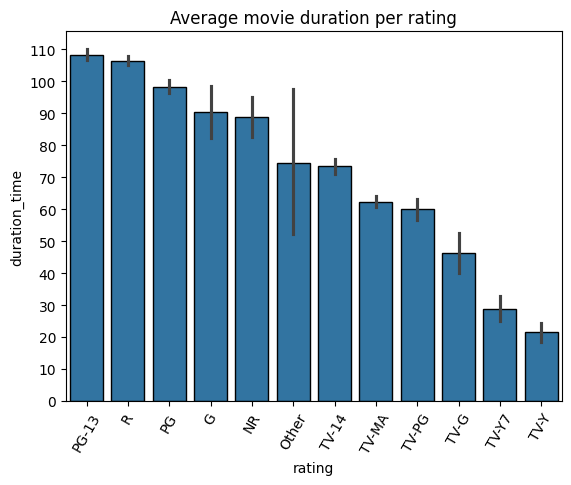

In [35]:
# Average movie duration per rating
def average_movie_duration():
    duration_rating_df = df[['rating', 'duration_time']]
    sort = duration_rating_df.groupby('rating')['duration_time'].mean().sort_values(ascending=False)

    sns.barplot( x='rating', y='duration_time', data = duration_rating_df, estimator='mean', edgecolor='black', order = sort.index)
    plt.xticks(rotation=60)
    plt.title("Average movie duration per rating")
    plt.yticks(np.arange(0,sort.max() * 1.1, 10))
    plt.savefig("../plots/average_movie_duration.png")    
    plt.show()

average_movie_duration()

**Insights**
PG-13 has highest average duration, closely followed by R.  
Other or Unrated category had highest variations.  
TV-Y was has lowest duration.  

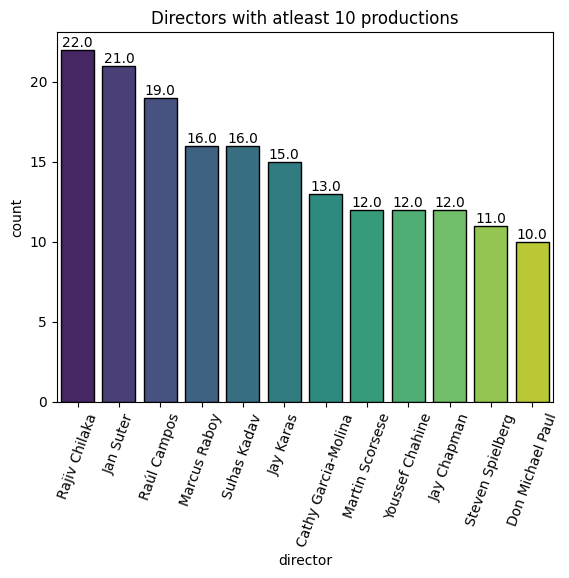

In [39]:
# top directors
def top_directors():
    t = df['director']
    # drop 'Unknown' or empty values
    # split by ',' as one cell may have more than 1 names
    # use, explode to separate names, and strip to remove blank space, and value_count to count
    t = t[t!='Unknown'].dropna().str.split(',').explode().str.strip().value_counts()
    # .explode().str.strip()

    t = t.reset_index()
    t.columns = ['director', 'count']
    t = t[t['count'] >= 10]

    ax = sns.barplot(data=t, x='director', y='count',  edgecolor='black', hue='director', palette='viridis')

    plt.xticks(rotation=70)

    for bar in ax.patches:
        height = bar.get_height()
        x = bar.get_x() + bar.get_width()/2
        y = height + 0.2
        ax.text(x, y, str(height),
                ha='center')

    plt.title("Directors with atleast 10 productions")
    plt.savefig("../plots/top_directors.png")

    plt.show()
top_directors()

**Insights**  
Rajiv Chilaka is most producing director, closely followed by Jan Suter